### 使用神经网络来预测房价
1. Adam Optimizer Algorithm: 


### Adam Optimizer Algorithm
1. 是什么
2. 有什么优势
    - 一阶优化
    - 实现直白
    - 计算高效
    - 所需内存少
    - 梯度对角缩放的不变性, 如何对角缩放
    - 适合大规模数据和参数
    - 适合高噪声或稀疏梯度
    - 调参少
    - 这么多好处, 难怪
2. 原理机制是怎样
    - 通过计算 梯度的一阶矩估计和二阶矩估计, 为不同参数设计独立的自适应性学习率
    
3. 和 AdaGrad and RMSProp 有啥不一样
    - AdaGrad, 为每个参数保留一个学习率, 以提升稀疏梯度上的性能
    - RMSProp, 均方根传播, 基于权重梯度 最近量级的均值, 为每个参数适应性地保留学习率
    - 算法计算 梯度的"指数移动均值"(Exponential Moving Average), 超参 beta1和beta2控制移动均值的衰减率
4. 如何调参, 有哪些常用的配置参数
    - 比较好的默认参数设定为：alpha=0.001、beta1=0.9、beta2=0.999 和 epsilon=10E−8
5. 如何实现 优化过程, 权重更新规则是怎样的
6. 初始化偏差修正的推导
7. 扩展形式: AdaMax
8. 论文:
    - [出处: Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
    - [RMSprop](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)
9. 其他优化算法: Insofar, Adadelta, SGD + Nesterov动量


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from IPython import display
from collections import Counter
from matplotlib import pyplot as plt
from mxnet import autograd, nd, init as ginit
from scipy.stats import pearsonr, kendalltau, spearmanr, pointbiserialr
from mxnet.gluon import nn, loss as gloss, data as gdata, Trainer as gTrainer
pd.set_option('display.max_columns', 999)

In [2]:
# 读取数据 using pandas
train_data = pd.read_csv("./DataResources/PA_1/train.csv")
test_data = pd.read_csv("./DataResources/PA_1/test.csv")
train_data = train_data.iloc[np.random.permutation(len(train_data))]  # 打乱 顺序

In [3]:
def PigTooProcess(train_data, test_data):
    all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]), sort=False)
    print("Before: ", all_features.shape)
    # 转换年份为距离今年的差值
    current_year = datetime.today().year
    year_cols = ['YrSold', 'YearRemodAdd', 'GarageYrBlt', 'YearBuilt']
    for col in year_cols:
        all_features[col] = current_year - all_features[col]
    # 归一化
    all_features['MoSold'] = all_features['MoSold'].apply(str)
    # 小整数不用归一化
    numerical_index = all_features.dtypes[all_features.dtypes != 'object'].index
    all_features[numerical_index] = all_features[numerical_index].apply(lambda x: (x - x.mean()) / x.std())
    all_features[numerical_index] = all_features[numerical_index].fillna(0)  # 如果归一化在fillna之后会如何
    # 将类型变量拆分, nan也作为一列: MoSold 和 object 列
    flatten_features = pd.get_dummies(all_features, dummy_na=True)
    # 去掉无用的列
    remove_cols = list()
    for col in flatten_features.columns:
        if len(set(flatten_features[col].values)) < 2:
            remove_cols.append(col)
            del flatten_features[col]
    print("Remove columns: ", ", ".join(remove_cols))
    print("After: ", flatten_features.shape)
    # 对sale price 取log
    return flatten_features

In [9]:
loss = gloss.L2Loss()
pig_data = PigTooProcess(train_data, test_data)
ptp_train_data = pig_data[:len(train_data)]
ptp_test_data = pig_data[len(train_data):]
train_X = nd.array(ptp_train_data.iloc[:ptp_train_data.shape[0], :].to_numpy())
train_y = nd.array(train_data.iloc[:, -1]).reshape((train_data.shape[0], 1))
test_X = nd.array(ptp_test_data.to_numpy())

Before:  (2919, 79)
Remove columns:  Street_nan, LotShape_nan, LandContour_nan, LotConfig_nan, LandSlope_nan, Neighborhood_nan, Condition1_nan, Condition2_nan, BldgType_nan, HouseStyle_nan, RoofStyle_nan, RoofMatl_nan, ExterQual_nan, ExterCond_nan, Foundation_nan, Heating_nan, HeatingQC_nan, CentralAir_nan, PavedDrive_nan, MoSold_nan, SaleCondition_nan
After:  (2919, 322)


In [137]:
# 定义模型
def get_net():
    net = nn.Sequential()
    net.add(
        nn.Dense(512, activation='relu'),
        nn.Dropout(0.2),
        nn.Dense(1)
    )
    net.initialize(ginit.Normal(sigma=0.01))  
    # Actual initialization happens during the first forward pass.
    return net

In [138]:
# 定义损失函数
def log_rmse(net, features, labels):
    """
    kaggle 的衡量标准
    将小于1的值设成1，使得取对数时数值更稳定
    """
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    rmse = rmse.asscalar()
    if np.isnan(rmse):
        raise Exception("get loss of NaN")
    return rmse

In [139]:
# 定义训练过程
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, 
          learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    trainer = gTrainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [141]:
k, num_epochs, learning_rate, weight_decay, batch_size = 5, 200, 0.02, 10, 73
train_loss, _ = train(get_net(), train_X, train_y, None, None, num_epochs, learning_rate, weight_decay, batch_size)
train_loss

[4.5613933,
 2.899464,
 1.8705031,
 1.1559719,
 0.6534869,
 0.3309961,
 0.20496538,
 0.19156127,
 0.18258461,
 0.17211896,
 0.16869363,
 0.16754425,
 0.16544534,
 0.16402203,
 0.1605397,
 0.1561545,
 0.15303704,
 0.14852439,
 0.14654656,
 0.14295107,
 0.14118017,
 0.13860539,
 0.13691324,
 0.13483004,
 0.13318941,
 0.13211152,
 0.12993108,
 0.12910639,
 0.12810586,
 0.12654962,
 0.12526508,
 0.12464271,
 0.12321585,
 0.122578956,
 0.12160413,
 0.12079652,
 0.12026174,
 0.119195625,
 0.11859412,
 0.11797785,
 0.117362626,
 0.117481604,
 0.11643039,
 0.1160416,
 0.11542846,
 0.11541744,
 0.11464259,
 0.114235096,
 0.11394538,
 0.113442995,
 0.11321974,
 0.112575,
 0.11226522,
 0.11217123,
 0.11159626,
 0.11124186,
 0.11077646,
 0.11036885,
 0.110327855,
 0.11017833,
 0.11013555,
 0.109480835,
 0.10930869,
 0.10848414,
 0.1083271,
 0.10801317,
 0.10759981,
 0.10725654,
 0.10690027,
 0.106438376,
 0.10644209,
 0.10562952,
 0.10579298,
 0.10482911,
 0.10444684,
 0.10373164,
 0.1032207,
 0.1

In [19]:
def train_and_pred(lr, wd):
    net = get_net()
    train_ls, _ = train(net, train_X, train_y, None, None, num_epochs, lr, wd, batch_size)
    print("Trainning history: ", train_ls)
    generate_submission(net, test_X)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    
def generate_submission(net, test_x):
    preds = net(test_x).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    return submission

In [21]:
def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """
    对数 plot: 10^1, 10^-1, 10^-2
    """
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [26]:
# k-fold
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    """
    选择最佳的参数组合
    :return 平均训练误差, 平均验证误差
    """
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

In [33]:
def float_range(start, end, step):
    result = list()
    counter = 0
    temp = start
    while True:
        counter += 1
        print(counter)
        if temp < end:
            result.append(round(temp, 2))
            temp += step
        elif counter == 1 and temp == end:
            return [temp]
        else:
            break
    return result

fold 0, train rmse 0.054641, valid rmse 0.139380
fold 1, train rmse 0.061307, valid rmse 0.125949
fold 2, train rmse 0.064335, valid rmse 0.109005
fold 3, train rmse 0.061058, valid rmse 0.153104
fold 4, train rmse 0.068013, valid rmse 0.135244
Learning Rate: 0.9, Weight Decay: 240, avg train rmse: 0.061870860308408736, avg valid rmse: 0.13253656327724456


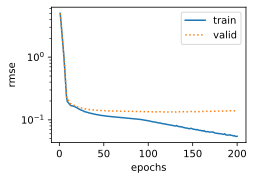

In [142]:
train_l, valid_l = k_fold(k, train_X, train_y, num_epochs, learning_rate, weight_decay, batch_size)
print('Learning Rate: {}, Weight Decay: {}, avg train rmse: {}, avg valid rmse: {}'.format( 
    try_lr, try_wd, train_l, valid_l))

Trainning history:  [4.4286494, 2.7297251, 1.7134998, 1.0212245, 0.546077, 0.27309915, 0.19477585, 0.18866764, 0.17833596, 0.17223696, 0.17028221, 0.16864456, 0.16755098, 0.16382092, 0.16143073, 0.1573109, 0.15434986, 0.15051374, 0.14712456, 0.14479744, 0.14371957, 0.140837, 0.13869688, 0.13767372, 0.13502818, 0.13431561, 0.13290617, 0.13125023, 0.13028543, 0.12915175, 0.12837575, 0.12696408, 0.12667722, 0.12588613, 0.12461554, 0.12402445, 0.123542264, 0.12285436, 0.1224146, 0.12152041, 0.12114612, 0.120742336, 0.12059143, 0.11958511, 0.11917982, 0.11911309, 0.118971825, 0.11817019, 0.117960095, 0.11767686, 0.117184274, 0.11688782, 0.11667602, 0.116352886, 0.11598481, 0.11593656, 0.11541668, 0.11511068, 0.11477025, 0.11475133, 0.1142771, 0.1139237, 0.113590255, 0.11375126, 0.11288988, 0.11281028, 0.11269471, 0.11200366, 0.11203939, 0.11135596, 0.11085242, 0.11061497, 0.11005758, 0.10946562, 0.11000249, 0.1095619, 0.10839648, 0.10762305, 0.107599646, 0.106559254, 0.10615432, 0.10556029,

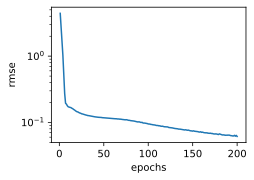

In [143]:
train_and_pred(learning_rate, weight_decay)  # 0.12372, 排名 1596
# 之前是因为迭代次数太多, 过拟合了吗

### Q&A
1. 测试时要不要关掉dropout
    - 别人例子也没有关掉: https://www.kaggle.com/zhunqiang/housing-prices-analysis-and-prediction
2. 之前为什么会失败?
    - 权重太小?
    - 第一隐藏层太多?
    - 迭代次数太多?
3. 为什么我得出的关于 dropout的心得. 不同于别人:
    - 别人:
        - 在测试时不要忘记关闭dropout, <b>对权值求乘积</b> (还要这样!!!!)
        - dropout网络会随着时间推移而工作得越来越好, 可是不会导致过拟合吗


### 他山之石
1. 权值初始化: 在深度网络, 小随机权重数值会导致比较差的结果, 这和浅层网络不同
    - `0.02*randn(num_params)。`
    - `init_scale/sqrt(layer_width)*randn`, init_scale 设置0.1或者 1
2. Ensembling, 训练多个神经网络, 最后对预测数据取平均
3. Learning rate 要朝着重点不断减小
4. 梯度归一化: 计算出